![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import  cross_val_score


In [2]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
X = data.drop(['Price'], axis=1)
y = data['Price']

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
class ArbolDecisiones:
  
  def fit(self, X, y, min_leaf = 2):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)

In [6]:
class Node:

    def __init__(self, x, y, idxs, min_leaf=2):
        self.x = x 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = np.mean(y.iloc[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for c in range(self.col_count): self.find_better_split(c)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, var_idx):
      
        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: continue

            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        y = self.y.iloc[self.idxs]
        lhs_std = y.iloc[lhs].std()
        rhs_std = y.iloc[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
                
    @property
    def is_leaf(self): return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

In [7]:
# Creación y Predicción del Modelo (Nota: Esto puede tardar varios minutos)
regressor = ArbolDecisiones().fit(X_train, y_train)
preds = regressor.predict(X_test)

In [8]:
# Métricas
rmse = np.sqrt(np.square(y_test - preds).mean())
mae = np.mean(np.abs(y_test - preds))
r2 = r2_score(y_test, preds)

print("RMSE: ", rmse) 
print("MAE: ", mae)
print('R2: ',r2)

RMSE:  1909.1527735564216
MAE:  1439.232282043881
R2:  0.7617135477567326


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2
#juan A

# Siguiendo el ejemplo del taller de ensamblajes de la semana 1

# Fijamos una semilla para el muestreo aleatorio
np.random.seed(10)
# Se crea un arreglo de 1 a 20
nums = np.arange(1, 21)
# Impresión del arreglo y muestreo aleatorio

print('Arreglo:', nums)
print('Muestreo aleatorio: ', np.random.choice(a=nums, size=20, replace=True))

# Creación de 10 muestras de bootstrap 
np.random.seed(10)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples
# Visualización muestra boostrap #1 para entrenamiento
X_train.iloc[samples[0], :]

# Construcción un árbol de decisión para cada muestra boostrap
from sklearn.tree import DecisionTreeRegressor

# Definición del modelo usando DecisionTreeRegressor de sklearn
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train = X_train.iloc[sample, :]
    y_train = y_train.iloc[sample]
    treereg.fit(X_train, y_train)
    y_pred.iloc[:,i] = treereg.predict(X_test)
    
y_pred

# Desempeño de cada árbol
for i in range(n_B):
    print('El error para el Árbol ', i, 'es de: ', np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test)))
    
# Predicciones promedio para cada obserbación del set de test
y_pred.mean(axis=1)

# Error al promediar las predicciones de todos los árboles
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))




Arreglo: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Muestreo aleatorio:  [10  5 16  1 18 17 18  9 10  1 11  9  5 20 17  5 16 12 12  2]
El error para el Árbol  0 es de:  2113.00323685644
El error para el Árbol  1 es de:  2105.520748636893
El error para el Árbol  2 es de:  2132.155284246368
El error para el Árbol  3 es de:  2164.8765342063302
El error para el Árbol  4 es de:  2173.246527982559
El error para el Árbol  5 es de:  2211.1463504439357
El error para el Árbol  6 es de:  2205.2016523719126
El error para el Árbol  7 es de:  2158.4458544850386
El error para el Árbol  8 es de:  2201.116595793789
El error para el Árbol  9 es de:  2185.6331294785878


1866.5609466813003

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [10]:
# Celda 3
# Uso de BaggingRegressor de la libreria (sklearn) donde se usa el modelo DecisionTreeRegressor como estimador

# , max_features= math.log(n_features)

from sklearn.ensemble import BaggingRegressor
import math
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, 
                          bootstrap=True, oob_score=True, random_state=1 )
# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred))

1950.0462869793325

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [11]:
# Celda 4
# Implementación modelo Random Forest para Regresión
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# metricas de desempeño 
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
adj_r2 = r2_score(y_test, y_pred)

# Imprimir las métricas de evaluación
print("Adjusted R2: ", adj_r2)
print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)


# Distribución de r2 
print('Distribución de r2:')
pd.Series(cross_val_score(rf_model, X, y, cv=10,scoring='r2')).describe()

Adjusted R2:  0.7515825687613372
MSE:  3799829.244465185
RMSE:  1949.3150705992052
MAE:  1461.0927655889145
MAPE:  10.583339276864475
Distribución de r2:


count    10.000000
mean      0.801210
std       0.011270
min       0.780913
25%       0.795153
50%       0.803178
75%       0.805612
max       0.817196
dtype: float64

Aplicando el modelo de Random Forest para predecir el precio de un automóvil se tiene un MSE de 3.078.505 y un R2 de 0.79, esto sin realizar calibración de parámetros. Adicionalmente se realiza con un modulo de "ensemble" utilizando validación cruzada y después de aplicar con k-fold cross validation un k de 10 se obtiene la distribución del r2 identificando así que el promedio del r2 está en 0.80 con un mínimo del 0.78 y un máximo de 0.81 siendo un resultado no tan disperso.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

**************************Calibración de n_estimators************************


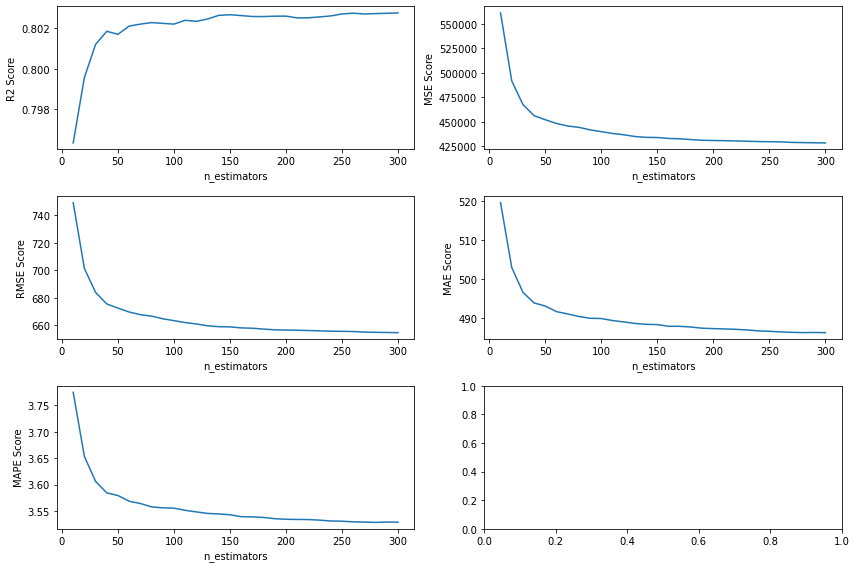

In [12]:
# Calibración de n_estimators
print('**************************Calibración de n_estimators************************')
estimator_range = range(10, 310, 10)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for estimator in estimator_range:
    rf_model = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Visualización de las métricas
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.ravel()

axes[0].plot(estimator_range, R2_scores)
axes[0].set_xlabel('n_estimators')
axes[0].set_ylabel('R2 Score')

axes[1].plot(estimator_range, MSE_scores)
axes[1].set_xlabel('n_estimators')
axes[1].set_ylabel('MSE Score')

axes[2].plot(estimator_range, RMSE_scores)
axes[2].set_xlabel('n_estimators')
axes[2].set_ylabel('RMSE Score')

axes[3].plot(estimator_range, MAE_scores)
axes[3].set_xlabel('n_estimators')
axes[3].set_ylabel('MAE Score')

axes[4].plot(estimator_range, MAPE_scores)
axes[4].set_xlabel('n_estimators')
axes[4].set_ylabel('MAPE Score')

plt.tight_layout()
plt.show()

**************************Calibración de max_features************************


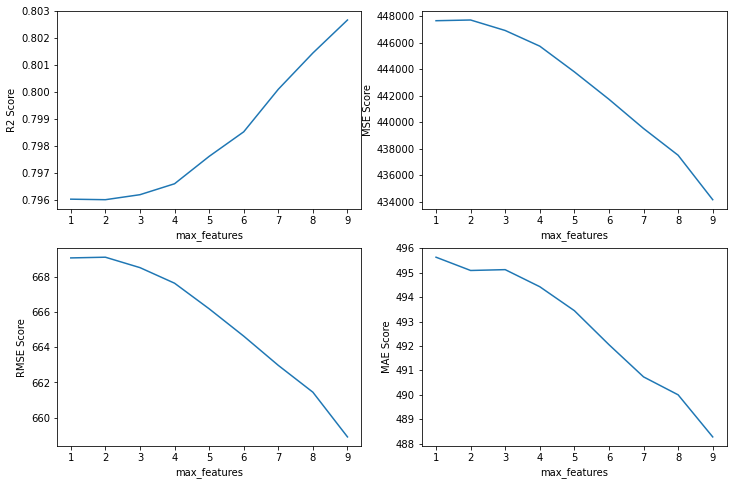

In [13]:
print('**************************Calibración de max_features************************')
feature_range = range(1, len(X.columns)+1)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for feature in feature_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Graficar resultados
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].plot(feature_range, R2_scores)
axes[0,0].set_xlabel('max_features')
axes[0,0].set_ylabel('R2 Score')

axes[0,1].plot(feature_range, MSE_scores)
axes[0,1].set_xlabel('max_features')
axes[0,1].set_ylabel('MSE Score')

axes[1,0].plot(feature_range, RMSE_scores)
axes[1,0].set_xlabel('max_features')
axes[1,0].set_ylabel('RMSE Score')

axes[1,1].plot(feature_range, MAE_scores)
axes[1,1].set_xlabel('max_features')
axes[1,1].set_ylabel('MAE Score')

plt.show()

**************************Calibración de max_depth************************


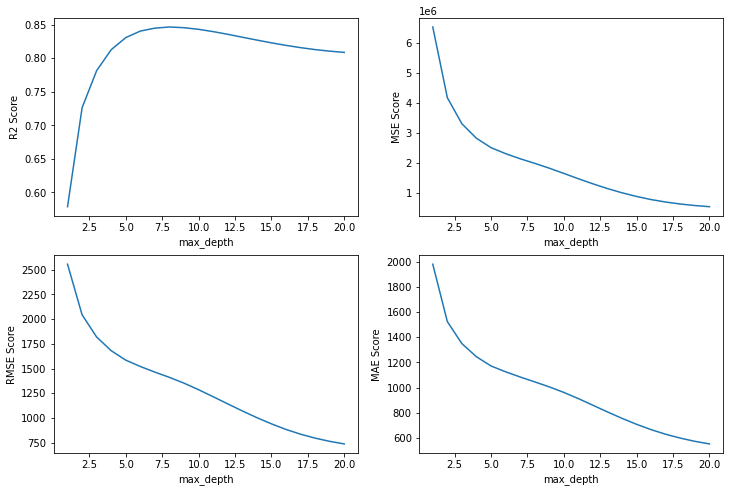

In [14]:
print('**************************Calibración de max_depth************************')
depth_range = range(1, 21)
R2_scores = []
MSE_scores = []
RMSE_scores = []
MAE_scores = []
MAPE_scores = []

for depth in depth_range:
    rf_model = RandomForestRegressor(n_estimators=150, max_depth=depth, random_state=1, n_jobs=-1)
    scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
    R2_scores.append(scores.mean())
    
    # Predicción y evaluación del modelo 
    rf_model.fit(X, y)
    y_pred = rf_model.predict(X)
    MSE_scores.append(mean_squared_error(y, y_pred))
    RMSE_scores.append(np.sqrt(mean_squared_error(y, y_pred)))
    MAE_scores.append(mean_absolute_error(y, y_pred))
    MAPE_scores.append(np.mean(np.abs((y - y_pred) / y)) * 100)

# Graficar resultados
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0,0].plot(depth_range, R2_scores)
axes[0,0].set_xlabel('max_depth')
axes[0,0].set_ylabel('R2 Score')

axes[0,1].plot(depth_range, MSE_scores)
axes[0,1].set_xlabel('max_depth')
axes[0,1].set_ylabel('MSE Score')

axes[1,0].plot(depth_range, RMSE_scores)
axes[1,0].set_xlabel('max_depth')
axes[1,0].set_ylabel('RMSE Score')

axes[1,1].plot(depth_range, MAE_scores)
axes[1,1].set_xlabel('max_depth')
axes[1,1].set_ylabel('MAE Score')

plt.show()

Se procede a validar los parámetros más optimos para aplicar al modelo, iniciando con el número de arboles (n_estimators) que van a ser usados se selecciona un rango entre 10 y 310 para probar el cambio en los resultados del r2 a medida que va iterando sobre esta variable y por cada arbol se está haciendo una validación cruzada de 5, para este caso se evidencia que se alcanza el máximo r2 con aproximadamente 150 árboles de igual forma se evidencia para las métricas del MSE, RMSE, MAPE Y EL MAE.

Posteriormente se busca identificar el número máximo de variables (max_features) con las cuáles nuestro modelo tendría un mejor desempeño, para lo cuál se itera sobre el número total de variables que tenemos en el dataset, sin embargo en este caso al tener pocas variables nos arroja que el r2 llega a su punto máximo cuando toma todas las variables entendiendo que los árboles serían iguales y ya no tendrían tanta aleatoriedad, de igual forma se da para las demás métricas como el MSE, RMSE , MAPE Y MAE. Esto podría ser de mayor impacto si tuvieramos un mayor número de variables en nuestro dataset.

Por último se realiza iteración sobre la profundidad de los árboles (max_depth) en donde se busca limitar la profundidad que puede alcanzar cada arbol de decisión individual, para este caso se evidencia que alcanza un máximo r2 con aproximadamente 8 y para las demás métricas entre más alta sea la profundidad se alcanza un mjeor resultado, sin embargo esto puede representar cierta complejidad computacional para datasets más grandes.

In [23]:
#Implementación del modelo Random Forest para Regresión con los mejores parámetros

rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print('***Métricas para Test:')
print('R2: ', r2)
print('MSE: ', mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print('                          ')

print('***Métricas para Train:')
rf_model = RandomForestRegressor(n_estimators=150, max_depth=8,max_features=9)
rf_model.fit(X_train, y_train)
y_pred_train = rf_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred_train)
mape = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
print('R2: ', r2)
print('MSE: ', mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)

***Métricas para Test:
R2:  0.8055809313111697
MSE:  2973862.4185987688
RMSE:  1724.4890311622073
MAE:  1271.659145135512
MAPE:  9.258892573268378
                          
***Métricas para Train:
R2:  0.9292498192542474
MSE:  1107682.7956657032
RMSE:  1052.4651042508265
MAE:  735.1556631782254
MAPE:  5.206432874671543


En este paso se entrena el modelo Random Forest utilizando los mejores parametros identificados en el paso anterior con lo cuál se evidencia un mejor desempeño del modelo con calibración de n_estimators=150, max_depth=8,max_features=9 en donde se obtuvo un r2 0.84 evaluando test y 0.87 evaluando con train a diferencia del modelo aplicado en el punto 4 con el cuál se obtuvo un r2 0.79. Adicionalmente se validan las metricas de desempñeo sobre train con el fin de descartar que el modelo tenga overfitting encontrando un buen resultado también para este caso.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [17]:
# Celda 6
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
model = xgb.XGBRegressor()

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
yPred = model.predict(X_test)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, yPred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, yPred)
mape = np.mean(np.abs((y_test - yPred) / y_test)) * 100
adj_r2 = r2_score(y_test, yPred)

# Imprimir las métricas de evaluación
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MAPE: ", mape)
print("R2 Ajustado: ", adj_r2)



RMSE:  1808.2736525682112
MAE:  1362.6027492320566
MAPE:  9.864948016905288
R2 Ajustado:  0.7862302276712319


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

*------Learning rate---------*
------------- Evaluación con test----------------


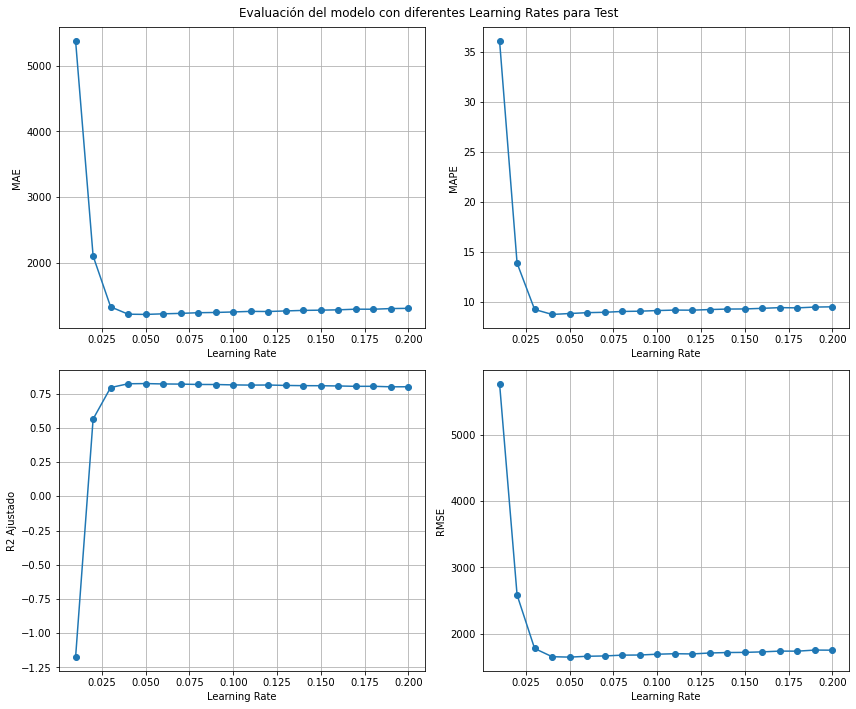

El mejor valor de learning rate para datos de prueba es: 0.05
------------- Evaluación con train----------------


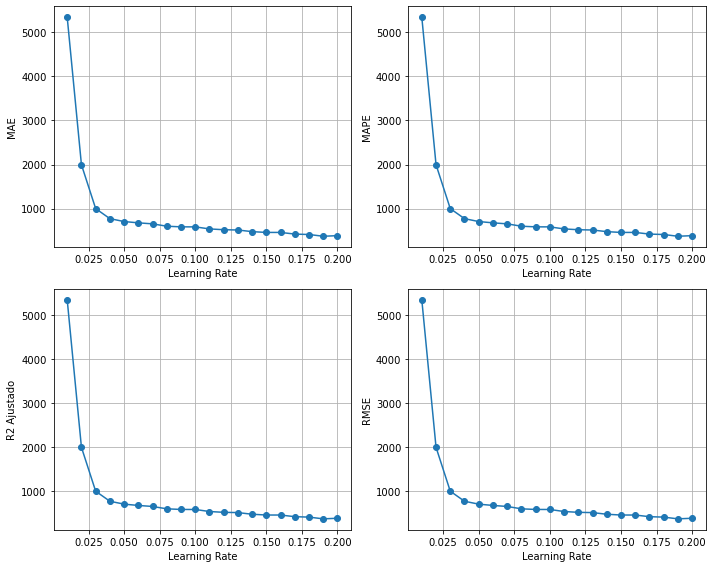

El mejor valor de learning rate para datos de prueba es: 0.19


In [18]:
# Celda 7
## Learning rate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de learning rate a calibrar
print('*------Learning rate---------*')
learning_rates = np.arange(0.01, 0.21, 0.01)

# Crear listas para guardar los resultados de las métricas y el learning rate
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
learning_rate_results = []

# Iterar sobre los diferentes valores de learning rate
for lr in learning_rates:
    # Crear el modelo de XGBoost con el valor de learning rate actual
    model = XGBRegressor(learning_rate=lr)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de learning rate
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    learning_rate_results.append(lr)

# Obtener el índice del mejor valor de learning rate basado en el MAE en datos de prueba
best_lr_idx_test = np.argmin(mae_results_test)
best_lr_test = learning_rates[best_lr_idx_test]

# Obtener el índice del mejor valor de learning rate basado en el MAE en datos de entrenamiento
best_lr_idx_train = np.argmin(mae_results_train)
best_lr_train = learning_rates[best_lr_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes Learning Rates para Test')

# Gráfico para el MAE
axes[0, 0].plot(learning_rate_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(learning_rate_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(learning_rate_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(learning_rate_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de learning rate para datos de prueba y de entrenamiento
print(f"El mejor valor de learning rate para datos de prueba es: {best_lr_test}")

print('------------- Evaluación con train----------------')


# Gráfico para el MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(learning_rate_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(learning_rate_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('Learning Rate')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(learning_rate_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(learning_rate_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('Learning Rate')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de learning rate para datos de prueba es: {best_lr_train}")


*------gamma---------*
------------- Evaluación con test----------------


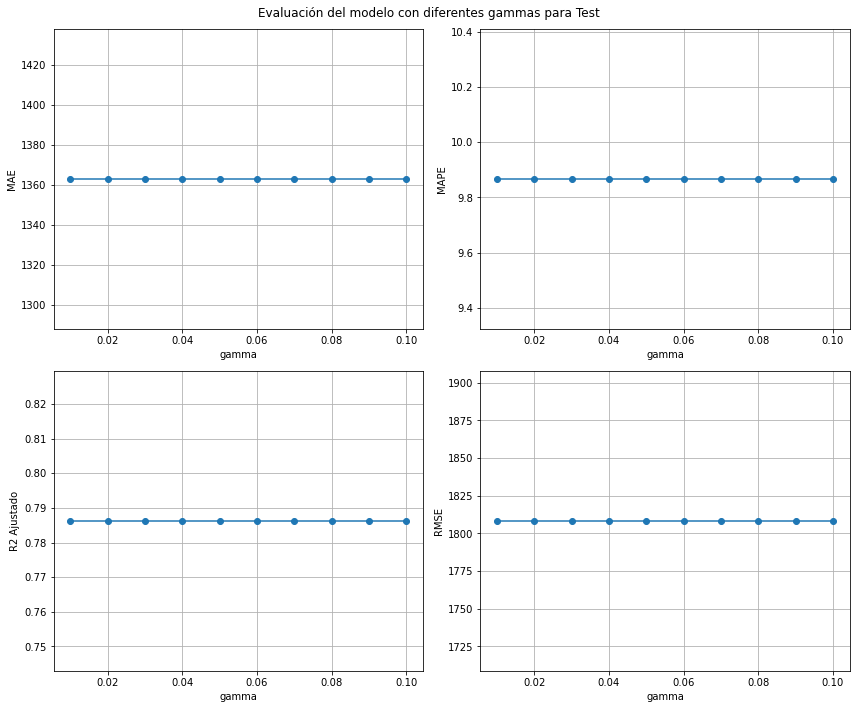

El mejor valor de gamma para datos de prueba es: 0.01
------------- Evaluación con train----------------


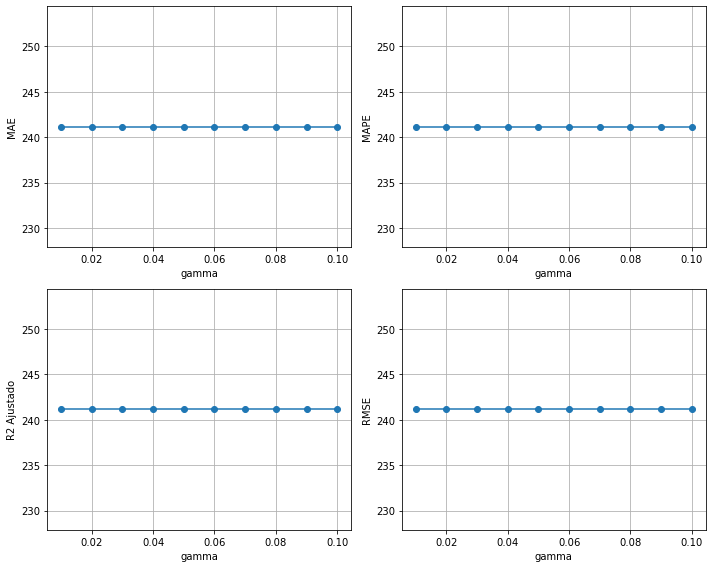

El mejor valor de gamma para datos de prueba es: 0.01


In [19]:
## gamma
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de gamma a calibrar
print('*------gamma---------*')
gammas = np.arange(0.01, 0.11, 0.01)

# Crear listas para guardar los resultados de las métricas y el gamma
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
gamma_results = []

# Iterar sobre los diferentes valores de gamma
for gam in gammas:
    # Crear el modelo de XGBoost con el valor de gamma actual
    model = XGBRegressor(gamma=gam)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de gamma
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    gamma_results.append(gam)

# Obtener el índice del mejor valor de gamma basado en el MAE en datos de prueba
best_gam_idx_test = np.argmin(mae_results_test)
best_gam_test = gammas[best_gam_idx_test]

# Obtener el índice del mejor valor de gamma basado en el MAE en datos de entrenamiento
best_gam_idx_train = np.argmin(mae_results_train)
best_gam_train = gammas[best_gam_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes gammas para Test')

# Gráfico para el MAE
axes[0, 0].plot(gamma_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('gamma')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

# Gráfico para el MAPE
axes[0, 1].plot(gamma_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('gamma')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

# Gráfico para el R2 ajustado
axes[1, 0].plot(gamma_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# Gráfico para el RMSE
axes[1, 1].plot(gamma_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('gamma')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de gamma para datos de prueba y de entrenamiento
print(f"El mejor valor de gamma para datos de prueba es: {best_gam_test}")

print('------------- Evaluación con train----------------')


#MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(gamma_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('gamma')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(gamma_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('gamma')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(gamma_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('gamma')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

#RMSE
axes[1, 1].plot(gamma_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('gamma')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de gamma para datos de prueba es: {best_gam_train}")


*------colsamp---------*
------------- Evaluación con test----------------


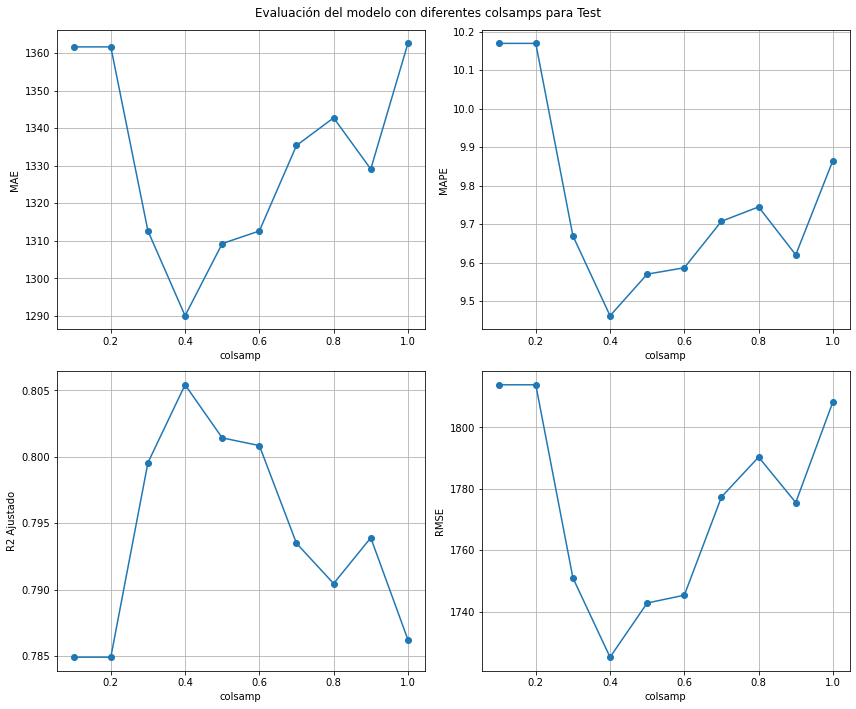

El mejor valor de colsamp para datos de prueba es: 0.4
------------- Evaluación con train----------------


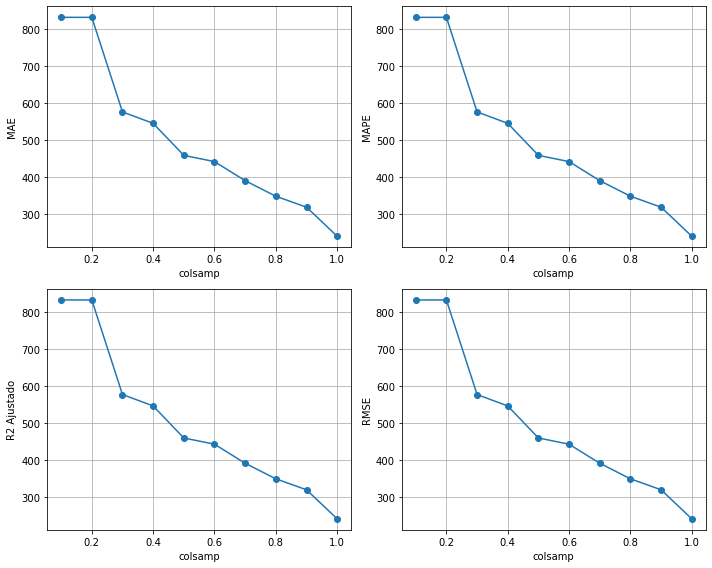

El mejor valor de colsamp para datos de prueba es: 1.0


In [20]:


## colsample_bytree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Definir los posibles valores de colsamp a calibrar
print('*------colsamp---------*')
colsample_bytrees = np.arange(0.1, 1.1, 0.1)

# Crear listas para guardar los resultados de las métricas y el colsamp
mae_results_train = []
mape_results_train = []
adj_r2_results_train = []
rmse_results_train = []
mae_results_test = []
mape_results_test = []
adj_r2_results_test = []
rmse_results_test = []
colsample_bytree_results = []

# Iterar sobre los diferentes valores de colsamp
for col in colsample_bytrees:
    # Crear el modelo de XGBoost con el valor de colsamp actual
    model = XGBRegressor(colsample_bytree=col)
    model.fit(X_train, y_train)
    
    # Hacer predicciones en datos de prueba
    y_pred_test = model.predict(X_test)
    # Hacer predicciones en datos de entrenamiento
    y_pred_train = model.predict(X_train)
    
    # Calcular las métricas de evaluación en datos de prueba
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    adj_r2_test = r2_score(y_test, y_pred_test)
    
    # Calcular las métricas de evaluación en datos de entrenamiento
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    adj_r2_train = r2_score(y_train, y_pred_train)
    
    # Guardar los resultados de las métricas y el valor de colsamp
    mae_results_train.append(mae_train)
    mape_results_train.append(mape_train)
    adj_r2_results_train.append(adj_r2_train)
    rmse_results_train.append(rmse_train)
    mae_results_test.append(mae_test)
    mape_results_test.append(mape_test)
    adj_r2_results_test.append(adj_r2_test)
    rmse_results_test.append(rmse_test)
    colsample_bytree_results.append(col)

# Obtener el índice del mejor valor de colsamp basado en el MAE en datos de prueba
best_col_idx_test = np.argmin(mae_results_test)
best_col_test = colsample_bytrees[best_col_idx_test]

# Obtener el índice del mejor valor de colsamp basado en el MAE en datos de entrenamiento
best_col_idx_train = np.argmin(mae_results_train)
best_col_train = colsample_bytrees[best_col_idx_train]

print('------------- Evaluación con test----------------')


# Generar los subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Evaluación del modelo con diferentes colsamps para Test')

#MAE
axes[0, 0].plot(colsample_bytree_results, mae_results_test, marker='o')
axes[0, 0].set_xlabel('colsamp')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(colsample_bytree_results, mape_results_test, marker='o')
axes[0, 1].set_xlabel('colsamp')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(colsample_bytree_results, adj_r2_results_test, marker='o')
axes[1, 0].set_xlabel('colsamp')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

# RMSE
axes[1, 1].plot(colsample_bytree_results, rmse_results_test, marker='o')
axes[1, 1].set_xlabel('colsamp')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Imprimir el mejor valor de colsamp para datos de prueba y de entrenamiento
print(f"El mejor valor de colsamp para datos de prueba es: {best_col_test}")

print('------------- Evaluación con train----------------')


#MAE
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[0, 0].set_xlabel('colsamp')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True)

#MAPE
axes[0, 1].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[0, 1].set_xlabel('colsamp')
axes[0, 1].set_ylabel('MAPE')
axes[0, 1].grid(True)

#R2 ajustado
axes[1, 0].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[1, 0].set_xlabel('colsamp')
axes[1, 0].set_ylabel('R2 Ajustado')
axes[1, 0].grid(True)

#RMSE
axes[1, 1].plot(colsample_bytree_results, mae_results_train, marker='o')
axes[1, 1].set_xlabel('colsamp')
axes[1, 1].set_ylabel('RMSE')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
print(f"El mejor valor de colsamp para datos de prueba es: {best_col_train}")


Luego de realizar pruebas con varios valores para los hiperparametros se obtuvo lo siguiente:
1. Learning rate:
Se realizó una evaluación del modelo para valores entre 0.01 y 0.2, encontrando así el valor de 0.05 en donde se puede observar que se encuentra el menor valor de MAE, MAPE y RMSE donde tienen una reducción significativa, igualmente con R2 ajustado con su mayor valor,
un learning rate bajo evita el posible sobreajuste presentado en el modelo.
2. gamma:
Se realizó una evaluación del modelo para valores entre 0.01 y 0.1,se puede observar que los valores a utilizar no generan mayor variación en los indicadores de desempeño del modelo tanto para test como para train, este valor nos garantiza un modelo más complejo al regular la función de pérdida.
3. Colsample_bytree:
Se realizó una evaluación del modelo para valores entre 0.1 y 1, encontrando así el valor de 0.4 en donde se puede observar que se encuentra el menor valor de MAE, MAPE y RMSE, igualmente con R2 ajustado con su mayor valor, este parámetro es utilizado para seleccionar el porcentaje de variables para incluir en el modelo.

In [21]:
#Evaluar el modelo con los mejores parámetros.
model = XGBRegressor(colsample_bytree=0.4,learning_rate=0.05,gamma=0.01)

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones en datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
yPred = model.predict(X_test)
# Calcular las métricas de evaluación en datos de entrenamiento
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
adj_r2_train = r2_score(y_train, y_train_pred)

# Calcular las métricas de evaluación en datos de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
adj_r2_test = r2_score(y_test, y_test_pred)

# Imprimir las métricas de evaluación
print("Métricas en datos de entrenamiento:")
print("RMSE: ", rmse_train)
print("MAE: ", mae_train)
print("MAPE: ", mape_train)
print("R2 Ajustado: ", adj_r2_train)
print('-----------------------------')
print("Métricas en datos de prueba:")
print("RMSE: ", rmse_test)
print("MAE: ", mae_test)
print("MAPE: ", mape_test)
print("R2 Ajustado: ", adj_r2_test)

Métricas en datos de entrenamiento:
RMSE:  1185.5230246699523
MAE:  882.0427487421775
MAPE:  6.18705620912924
R2 Ajustado:  0.9102298130890994
-----------------------------
Métricas en datos de prueba:
RMSE:  1629.16697442094
MAE:  1214.2935602130847
MAPE:  8.87887544271212
R2 Ajustado:  0.8264801429484699


Por último, se evalua de nuevo el modelo con los parámetros obtenidos observando que aumenta el r2 ajustado en 0.02 con un valor final de r2 ajustado de 0.84, además obteniendo menores valores de RMSE,MAE y MAPE, para validar el sobreajuste se evalua el modelo con los datos en entrenamiento y prueba, obteniendo valores muy similares, comprobando así que el modelo no sufre de sobreajuste.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [22]:
# Celda 8

RMSE:  1621.4197004256812
MAE:  1186.634392366123
MAPE:  8.648872393314532
Adjusted R2:  0.8281265175296673

SyntaxError: invalid syntax (<ipython-input-22-bedfa56514bb>, line 6)